Subjects kept (have larbi_leaky): 99, models: ['MB', 'MF', 'hybrid', 'larbi', 'larbi_decay', 'larbi_leaky', 'larbi_mini', 'larbi_star', 'randomagent']
BOR = 0.0000


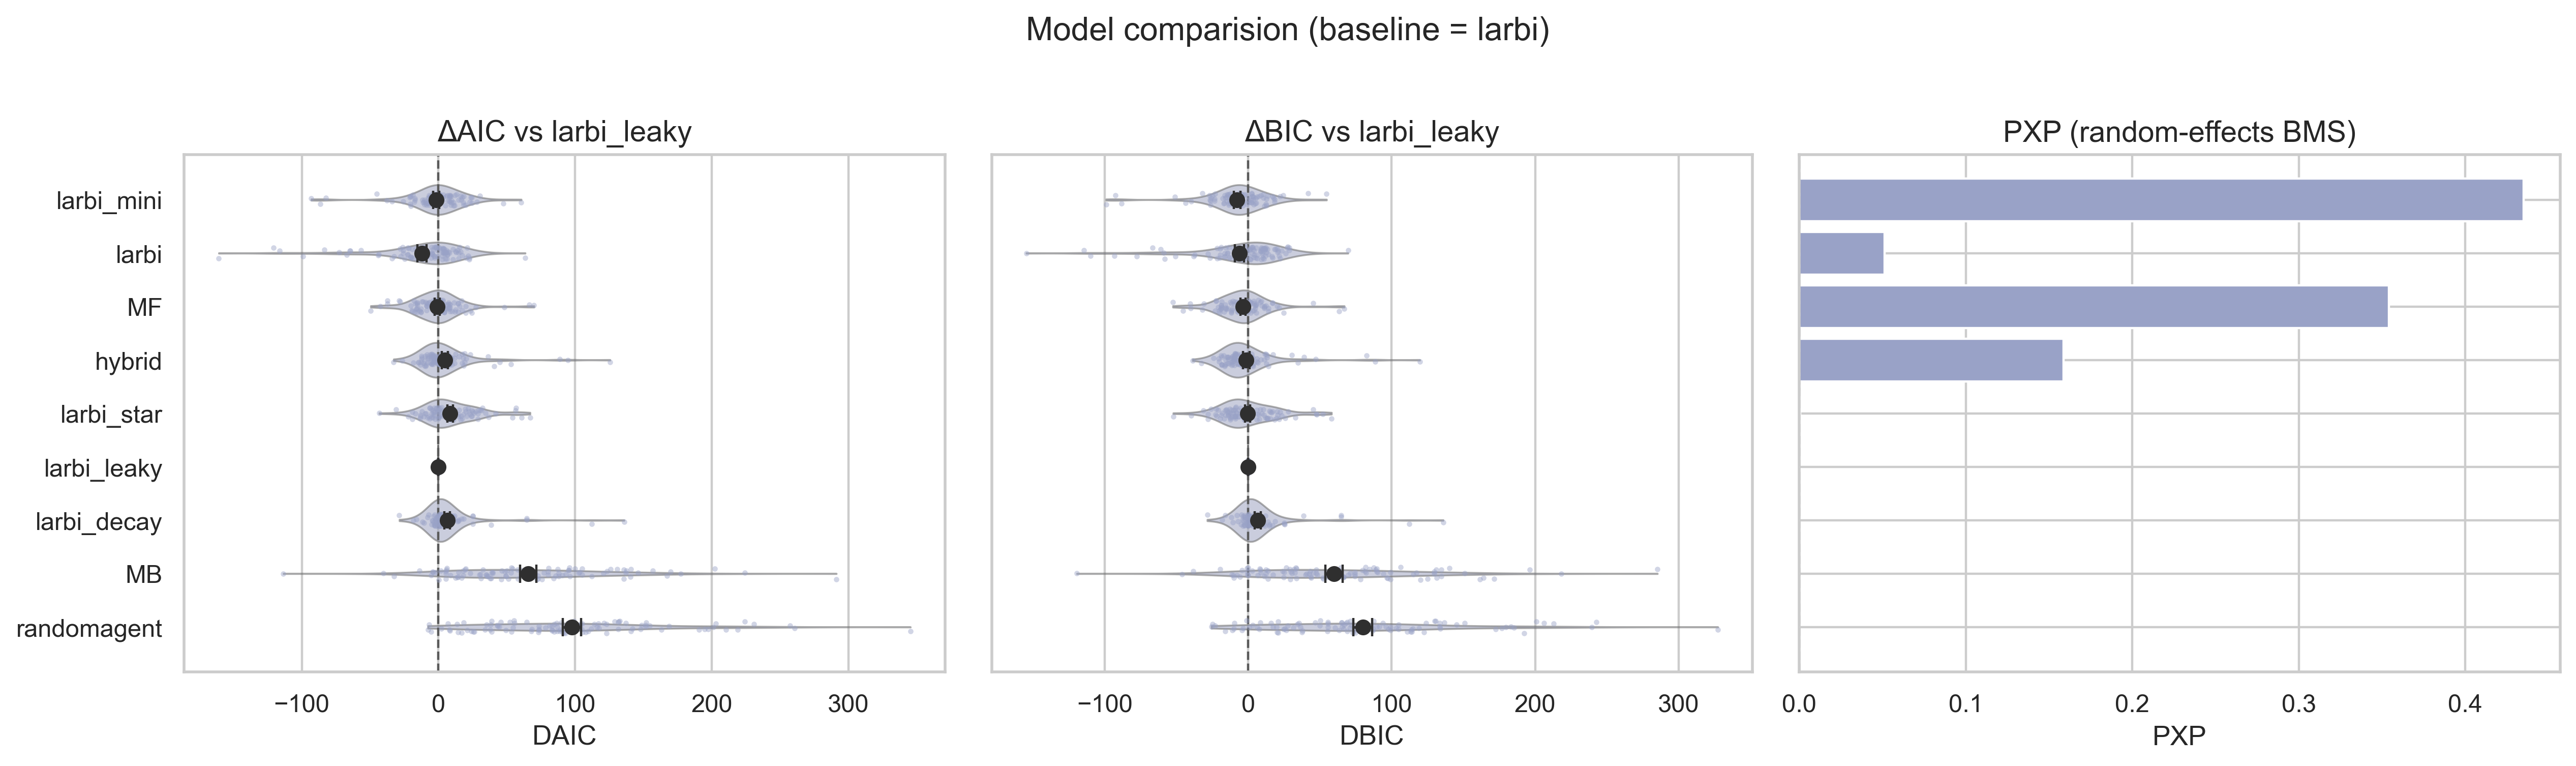

In [1]:
# %% ------------------ 0. Imports & style ------------------
import os, re, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.special import psi as digamma, gammaln
from scipy.stats import sem

# 显示更清晰
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
sns.set_theme(style="whitegrid")
mpl.rcParams.update({
    "figure.dpi": 160, "savefig.dpi": 300,
    "font.size": 12, "axes.titlesize": 13, "axes.labelsize": 12
})

# 统一配色：接近你师兄图的灰蓝
COLOR = "#99A2C7"   # bar/violin
DOT   = "#2F2F2F"   # 均值点/误差线
DASH  = "#5A5A5A"   # 虚线

# %% ------------------ 1. Load results ------------------
# 任选一种数据来源：
USE_CSV = True
CSV_PATH = Path("PKL_DATA/fitdata/IC_detail_ALL.csv")  # 你的目录里有这个
PKL_DIR  = Path("PKL_DATA/fitdata")                    # 若 USE_CSV=False 则从 pkl 汇总

def load_from_csv(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # 兼容字段名
    needed = {"subj","model","aic","bic"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"CSV缺少列: {miss}")
    return df[["subj","model","aic","bic"]].copy()

def load_from_pkls(pkl_dir: Path) -> pd.DataFrame:
    pat = re.compile(r"^fitresults_(?P<group>.+)_(?P<model>.+)\.pkl$")
    rows = []
    for p in pkl_dir.glob("fitresults_*.pkl"):
        m = pat.match(p.name)
        if not m: 
            continue
        model = m.group("model")
        with open(p, "rb") as f:
            lst = pickle.load(f)  # list[dict]
        for i, res in enumerate(lst):
            rows.append({
                "subj": res.get("subj", f"subj_{i:03d}"),
                "model": model,
                "aic": float(res["aic"]),
                "bic": float(res["bic"]),
            })
    if not rows:
        raise RuntimeError("未在目录中找到 fitresults_*.pkl")
    return pd.DataFrame(rows)

df_raw = load_from_csv(CSV_PATH) if USE_CSV else load_from_pkls(PKL_DIR)

# %% ------------------ 2. ΔIC 相对基准（larbi） ------------------
BASELINE = "larbi_leaky"
base = (df_raw.loc[df_raw["model"]==BASELINE, ["subj","aic","bic"]]
                 .rename(columns={"aic":"aic_base", "bic":"bic_base"}))
df = df_raw.merge(base, on="subj", how="inner", validate="many_to_one")
df["dAIC"] = df["aic"] - df["aic_base"]
df["dBIC"] = df["bic"] - df["bic_base"]

# 只保留有基准的被试
subjects = df["subj"].unique()
models   = df["model"].unique().tolist()
print(f"Subjects kept (have {BASELINE}): {len(subjects)}, models: {models}")

# 模型顺序（按ΔBIC均值）
order = (df.groupby("model")["dBIC"].mean()
           .sort_values(ascending=True).index.tolist())

# %% ------------------ 3. VB-BMS: XP & PXP （与 fit_xyf.py 一致） ------------------
# 用 −0.5·BIC 作为每个被试×模型的 log evidence
# 注意：这里的 df 仍是 merge 过 baseline 的那个（用于 ΔIC 的第一、二幅图）；
#       PXP 本身与 baseline 无关，它对所有模型一起做 BMS。
M_ORDER = order  # 记录一下模型顺序，下面画图会用到

# 取出证据矩阵 (S×M)
_piv = df.pivot_table(index="subj", columns="model", values="bic")
_piv = _piv.loc[subjects, M_ORDER]              # 对齐被试/模型顺序
lme  = -0.5 * _piv.to_numpy(dtype=float)        # log model evidence

# ====== 下面这些函数与 fit_xyf.py 的 bms()/calc_BOR()/F0()/FE() 等价 ======
def _softmax(x, axis=1):
    z = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=axis, keepdims=True)

def _dirichlet_exceedence(alpha_post, n_sample=200_000):
    """采样近似 XP（和 fit_xyf.py 一致的思路，样本数可调）"""
    a = np.asarray(alpha_post, dtype=float).reshape(-1)
    m = a.size
    # 分块采样，避免一次放太多样本
    blk = int(np.ceil(n_sample * m * 8 / 2**28))
    blk = np.floor(n_sample/blk * np.ones([blk,]))
    blk[-1] = n_sample - blk[:-1].sum()
    blk = blk.astype(int)

    xp = np.zeros(m, dtype=float)
    from numpy.random import default_rng
    rng = default_rng(2025)
    for b in blk:
        # Gamma 采样再按行归一化等价于 Dirichlet 采样
        r = rng.gamma(shape=a, scale=1.0, size=(b, m))
        xp += (r == r.max(axis=1, keepdims=True)).sum(axis=0)
    return xp / n_sample

def _F0(lme_):
    m = lme_.shape[1]
    qm = _softmax(lme_, axis=1)
    return np.sum(qm * (lme_ - np.log(m) - np.log(qm + 1e-13)))

def _FE(lme_, p_m1D, alpha_post, alpha0):
    from scipy.special import psi as digamma, gammaln
    E_log_r   = digamma(alpha_post) - digamma(alpha_post.sum())
    E_log_rmD = (p_m1D * (lme_ + E_log_r)).sum() + ((alpha0 - 1) * E_log_r).sum() \
                + gammaln(alpha0.sum()) - np.sum(gammaln(alpha0))
    Ent_p     = -(p_m1D * np.log(p_m1D + 1e-13)).sum()
    Ent_alpha = np.sum(gammaln(alpha_post)) - gammaln(alpha_post.sum()) \
                - ((alpha_post - 1) * E_log_r).sum()
    return E_log_rmD + Ent_p + Ent_alpha

def _calc_BOR(lme_, p_m1D, alpha_post, alpha0):
    f0 = _F0(lme_)
    f1 = _FE(lme_, p_m1D, alpha_post, alpha0)
    return 1.0 / (1.0 + np.exp(f1 - f0))  # H0 概率（所有模型频率相等）

def vb_bms_like_fit_xyf(lme_, tol=1e-6, max_iter=1024):
    """返回 alpha_post, p_m1D, xp, pxp, bor（与 fit_xyf.py 的 bms() 对齐）"""
    S, M = lme_.shape
    alpha0 = np.ones((1, M))
    alpha  = np.ones((1, M))

    from scipy.special import psi as digamma
    for _ in range(max_iter):
        prev = alpha.copy()
        log_u = lme_ + (digamma(alpha) - digamma(alpha.sum()))   # S×M
        # 数值稳定：行归一化
        log_u -= log_u.max(axis=1, keepdims=True)
        u = np.exp(log_u)
        p_m1D = u / u.sum(axis=1, keepdims=True)                # S×M
        B = p_m1D.sum(axis=0, keepdims=True)                    # 1×M
        alpha = alpha0 + B
        if np.linalg.norm(alpha - prev) < tol:
            break

    xp  = _dirichlet_exceedence(alpha, n_sample=200_000)
    bor = _calc_BOR(lme_, p_m1D, alpha, alpha0)
    pxp = (1 - bor) * xp + bor / M
    return alpha, p_m1D, xp, pxp, bor

alpha, p_m1D, xp, pxp, bor = vb_bms_like_fit_xyf(lme)
print(f"BOR = {bor:.4f}")

# 序列化成 Series，方便按模型名索引
pxp_series = pd.Series(pxp, index=M_ORDER)

# %% ------------------ 4. Plot：ΔAIC / ΔBIC / PXP ------------------
def violin_panel(ax, data, xcol, ylabel_order, title):
    sns.violinplot(
        ax=ax, data=data, y="model", x=xcol, order=ylabel_order,
        orient="h", cut=0, inner=None, linewidth=0.8, color=COLOR, alpha=0.55
    )
    sns.stripplot(
        ax=ax, data=data, y="model", x=xcol, order=ylabel_order,
        orient="h", size=2.4, alpha=0.45, jitter=0.12, color=COLOR
    )
    m = data.groupby("model")[xcol].mean().reindex(ylabel_order)
    e = data.groupby("model")[xcol].apply(sem).reindex(ylabel_order).fillna(0.0)
    ax.errorbar(m.values, np.arange(len(ylabel_order)), xerr=e.values,
                fmt='o', color=DOT, ecolor=DOT,
                capsize=4, elinewidth=1.2, markersize=6, zorder=10)
    ax.axvline(0, ls="--", lw=1, color=DASH)
    ax.set_title(title); ax.set_xlabel(xcol.upper()); ax.set_ylabel("")

fig, axes = plt.subplots(1, 3, figsize=(16, 4.6), sharey=True, dpi=160)
violin_panel(axes[0], df, "dAIC", order, f"ΔAIC vs {BASELINE}")
violin_panel(axes[1], df, "dBIC", order, f"ΔBIC vs {BASELINE}")

# PXP 条形图
axes[2].barh(order, pxp_series[order].values, color=COLOR)
axes[2].axvline(0, ls="--", lw=1, color=DASH)
axes[2].set_xlim(0, max(0.25, pxp_series.max()*1.05))
axes[2].set_xlabel("PXP")
axes[2].set_title("PXP (random-effects BMS)")

fig.suptitle("Model comparision (baseline = larbi)", y=1.02)
fig.tight_layout()
plt.show()

# 同时保存（PNG + SVG）
fig.savefig("IC_vs_larbi_PXP.png", dpi=300, bbox_inches="tight")
fig.savefig("IC_vs_larbi_PXP.svg", bbox_inches="tight")
